**Objetivo de la sección:** Extraer y limpiar datos correspondientes a los egresos hospitalarios por covid-19 de pacientes con prestación de salud pública y privada (fonasa e isapre), para posteriormente comparar los datos entre sí y con otras variables para la investigación.

**Librerías a utilizar**

In [38]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

**Archivos:** Contienen los datos de egresos hospitalarios por isapre y por fonasa (2020).

In [39]:
# Archivos
archivo_isapre = Path("articles-20903_recurso_1 (2).xlsx")
archivo_fonasa = Path("EGRE_DATOS_ABIERTOS_2020.csv")


**Extracción de datos del archivo de isapre:** Año 2020

In [40]:

# Isapre 2020
def extraer_egresos_isapre(path):
    mujer = pd.read_excel(path, sheet_name="20 Patologías Mujer")
    hombre = pd.read_excel(path, sheet_name="20 Patologías Hombre")

    def extraer_totales(df):
        total = df[df.apply(lambda x: x.astype(str).str.contains("Total", case=False).any(), axis=1)]
        covid = df[df.apply(lambda x: x.astype(str).str.contains("Covid", case=False).any(), axis=1)]
        return total, covid

    total_m, covid_m = extraer_totales(mujer)
    total_h, covid_h = extraer_totales(hombre)

    def limpiar_numero(valor):
        return float(str(valor).replace(".", "").replace(",", "."))
    
    egresos_total_m = limpiar_numero(total_m.iloc[0, 3])
    egresos_total_h = limpiar_numero(total_h.iloc[0, 3])
    egresos_covid_m = limpiar_numero(covid_m.iloc[0, 3])
    egresos_covid_h = limpiar_numero(covid_h.iloc[0, 3])

    total_egresos = egresos_total_m + egresos_total_h
    covid_egresos = egresos_covid_m + egresos_covid_h
    porcentaje = round((covid_egresos / total_egresos) * 100, 2)

    return {
        "Sistema": "ISAPRE",
        "Total_egresos": int(total_egresos),
        "Egresos_COVID": int(covid_egresos),
        "%_COVID": f"{porcentaje:.2f} %",
    }


**Extracción de datos del archivo de fonasa:** Año 2020

In [41]:

# Fonasa 2020
def extraer_egresos_fonasa(path):
    try:
        df = pd.read_csv(path, sep=";", encoding="utf-8-sig")
    except UnicodeDecodeError:
        df = pd.read_csv(path, sep=";", encoding="latin-1")

    df.columns = (
        pd.Index(df.columns)
        .astype(str)
        .str.strip()
        .str.upper()
        .str.replace(r"\s+", "_", regex=True)
    )

    df = df[df["ANO_EGRESO"] == 2020]

    # Total de egresos
    total_egresos = len(df)

    # Egresos COVID
    covid_mask = df["DIAG1"].astype(str).str.upper().str.startswith("U071")
    covid_egresos = covid_mask.sum()

    porcentaje = round((covid_egresos / total_egresos) * 100, 2)

    return {
        "Sistema": "FONASA",
        "Total_egresos": int(total_egresos),
        "Egresos_COVID": int(covid_egresos),
        "%_COVID": f"{porcentaje:.2f} %",
    }


**Crear df**

In [42]:

res_isapre = extraer_egresos_isapre(archivo_isapre)
res_fonasa = extraer_egresos_fonasa(archivo_fonasa)
resumen = pd.DataFrame([res_isapre, res_fonasa])
display(resumen)


c:\Users\Dani\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\Dani\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
C:\Users\Dani\AppData\Local\Temp\ipykernel_7060\405399811.py:6: DtypeWarning: Columns (7,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=";", encoding="latin-1")


,Sistema,Total_egresos,Egresos_COVID,%_COVID
0,ISAPRE,373379,3903,1.05 %
1,FONASA,1277952,47081,3.68 %


Crear **Gráfico** comparativo

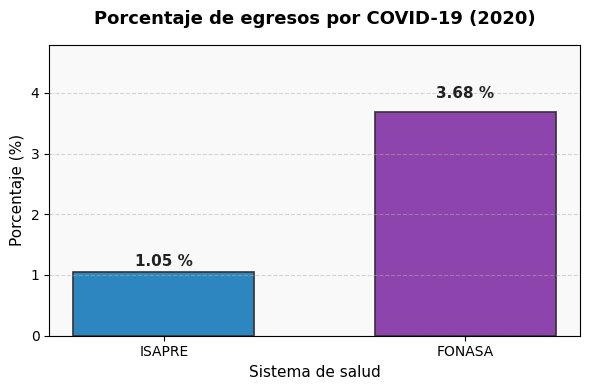

In [43]:


# Asegurar tipos
resumen = resumen.copy()
resumen["Total_egresos"]   = pd.to_numeric(resumen["Total_egresos"], errors="coerce")
resumen["Egresos_COVID"]   = pd.to_numeric(resumen["Egresos_COVID"], errors="coerce")
resumen["%_COVID_num"]     = (resumen["Egresos_COVID"] / resumen["Total_egresos"]) * 100

# Graficar
labels = resumen["Sistema"].astype(str).tolist()
values = resumen["%_COVID_num"].fillna(0).tolist()

plt.figure(figsize=(6, 4))
colors = ["#8E44AD" if s == "FONASA" else "#2E86C1" for s in resumen["Sistema"]]
bars = plt.bar(labels, values, color=colors, width=0.6, edgecolor="#333333", linewidth=1.2)

for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2,
             v + (0.02 if v == 0 else v*0.05),
             f"{v:.2f} %",
             ha="center", va="bottom",
             fontsize=11, fontweight="bold", color="#222222")

ymax = float(np.nanmax(values)) if values else 0.0
plt.ylim(0, (ymax * 1.3) if ymax > 0 else 1)
plt.title("Porcentaje de egresos por COVID-19 (2020)",
          fontsize=13, fontweight="bold", pad=15)
plt.ylabel("Porcentaje (%)", fontsize=11)
plt.xlabel("Sistema de salud", fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.gca().set_facecolor("#f9f9f9")
plt.tight_layout()
plt.show()





**Archivos:** Contienen los datos de egresos hospitalarios por isapre y por fonasa (2021).

In [44]:

# Archivos
archivo_isapre_2021 = Path("articles-21027_recurso_1.xlsx")
archivo_fonasa_2021 = Path("EGR_DATOS_ABIERTO_2021.csv")


**Extracción de datos del archivo de isapre:** Año 2021

In [45]:
# Isapre 2021 
def extraer_egresos_isapre(path):
    mujer = pd.read_excel(path, sheet_name="20 Patologías Mujer")
    hombre = pd.read_excel(path, sheet_name="20 Patologías Hombre")

    def extraer_totales(df):
        total = df[df.apply(lambda x: x.astype(str).str.contains("Total", case=False).any(), axis=1)]
        covid = df[df.apply(lambda x: x.astype(str).str.contains("Covid", case=False).any(), axis=1)]
        return total, covid

    total_m, covid_m = extraer_totales(mujer)
    total_h, covid_h = extraer_totales(hombre)

    def limpiar_numero(valor):
        return float(str(valor).replace(".", "").replace(",", "."))

    total_egresos = limpiar_numero(total_m.iloc[0, 3]) + limpiar_numero(total_h.iloc[0, 3])
    covid_egresos = limpiar_numero(covid_m.iloc[0, 3]) + limpiar_numero(covid_h.iloc[0, 3])
    porcentaje = round((covid_egresos / total_egresos) * 100, 2)

    return {
        "Sistema": "ISAPRE",
        "Total_egresos": int(total_egresos),
        "Egresos_COVID": int(covid_egresos),
        "%_COVID_num": porcentaje,
    }


**Extracción de datos del archivo de fonasa:** Año 2021

In [46]:
# Fonasa 2021
def extraer_egresos_fonasa(path):
    try:
        df = pd.read_csv(path, sep=";", encoding="utf-8-sig")
    except UnicodeDecodeError:
        df = pd.read_csv(path, sep=";", encoding="latin-1")

    df.columns = (
        pd.Index(df.columns)
        .astype(str)
        .str.strip()
        .str.upper()
        .str.replace(r"\s+", "_", regex=True)
    )

    df = df[df["ANO_EGRESO"] == 2021]

    total_egresos = len(df)
    covid_mask = df["DIAG1"].astype(str).str.upper().str.startswith("U07")
    covid_egresos = covid_mask.sum()
    porcentaje = round((covid_egresos / total_egresos) * 100, 2)

    return {
        "Sistema": "FONASA",
        "Total_egresos": int(total_egresos),
        "Egresos_COVID": int(covid_egresos),
        "%_COVID_num": porcentaje,
    }



**Crear df**

In [47]:

resumen_2021 = pd.DataFrame([
    extraer_egresos_isapre(archivo_isapre_2021),
    extraer_egresos_fonasa(archivo_fonasa_2021)
])

display(resumen_2021)

c:\Users\Dani\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\Dani\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
C:\Users\Dani\AppData\Local\Temp\ipykernel_7060\3378215324.py:6: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=";", encoding="latin-1")


,Sistema,Total_egresos,Egresos_COVID,%_COVID_num
0,ISAPRE,413087,8343,2.02
1,FONASA,1467062,89047,6.07


Crear **Gráfico** comparativo

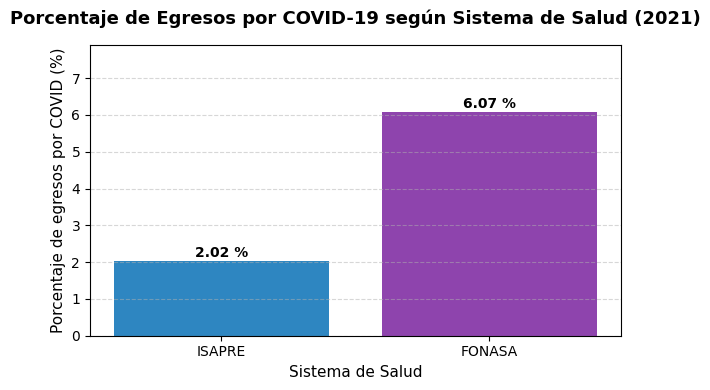

In [48]:

# Graficar
plt.figure(figsize=(6, 4))
bars = plt.bar(resumen_2021["Sistema"], resumen_2021["%_COVID_num"], color=["#2E86C1", "#8E44AD"])

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.05,
             f"{bar.get_height():.2f} %",
             ha="center", va="bottom", fontsize=10, fontweight="bold")

ymax = resumen_2021["%_COVID_num"].max()
plt.ylim(0, ymax * 1.3)
plt.title("Porcentaje de Egresos por COVID-19 según Sistema de Salud (2021)",
          fontsize=13, fontweight="bold", pad=15)
plt.ylabel("Porcentaje de egresos por COVID (%)", fontsize=11)
plt.xlabel("Sistema de Salud", fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


**Archivos:** Contienen los datos de egresos hospitalarios por isapre y por fonas (2022).

In [49]:

# Archivos
archivo_isapre_2022 = Path("articles-23605_recurso_1.xlsx")
archivo_fonasa_2022 = Path("EGRE_DATOS_ABIERTOS_2022.csv")


**Extracción de datos del archivo de isapre:** Año 2022

In [50]:

# Isapre 2022
def extraer_egresos_isapre(path):
    mujer = pd.read_excel(path, sheet_name="20 Patologías Mujer")
    hombre = pd.read_excel(path, sheet_name="20 Patologías Hombre")

    def extraer_totales(df):
        total = df[df.apply(lambda x: x.astype(str).str.contains("Total", case=False).any(), axis=1)]
        covid = df[df.apply(lambda x: x.astype(str).str.contains("Covid", case=False).any(), axis=1)]
        return total, covid

    total_m, covid_m = extraer_totales(mujer)
    total_h, covid_h = extraer_totales(hombre)

    def limpiar_numero(valor):
        return float(str(valor).replace(".", "").replace(",", "."))

    total_egresos = limpiar_numero(total_m.iloc[0, 3]) + limpiar_numero(total_h.iloc[0, 3])
    covid_egresos = limpiar_numero(covid_m.iloc[0, 3]) + limpiar_numero(covid_h.iloc[0, 3])
    porcentaje = round((covid_egresos / total_egresos) * 100, 2)

    return {
        "Sistema": "ISAPRE",
        "Total_egresos": int(total_egresos),
        "Egresos_COVID": int(covid_egresos),
        "%_COVID_num": porcentaje,
    }


**Extracción de datos del archivo de fonasa:** Año 2022

In [51]:
# Fonasa 2022
def extraer_egresos_fonasa(path):
    try:
        df = pd.read_csv(path, sep=";", encoding="utf-8-sig")
    except UnicodeDecodeError:
        df = pd.read_csv(path, sep=";", encoding="latin-1")

    df.columns = (
        pd.Index(df.columns)
        .astype(str)
        .str.strip()
        .str.upper()
        .str.replace(r"\s+", "_", regex=True)
    )

    df = df[df["ANO_EGRESO"] == 2022]

    total_egresos = len(df)
    covid_mask = df["DIAG1"].astype(str).str.upper().str.startswith("U07")
    covid_egresos = covid_mask.sum()
    porcentaje = round((covid_egresos / total_egresos) * 100, 2)

    return {
        "Sistema": "FONASA",
        "Total_egresos": int(total_egresos),
        "Egresos_COVID": int(covid_egresos),
        "%_COVID_num": porcentaje,
    }



**Crear df**

In [52]:
resumen_2022 = pd.DataFrame([
    extraer_egresos_isapre(archivo_isapre_2022),
    extraer_egresos_fonasa(archivo_fonasa_2022)
])

display(resumen_2022)

c:\Users\Dani\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
c:\Users\Dani\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
C:\Users\Dani\AppData\Local\Temp\ipykernel_7060\1182887222.py:6: DtypeWarning: Columns (7,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=";", encoding="latin-1")


,Sistema,Total_egresos,Egresos_COVID,%_COVID_num
0,ISAPRE,468597,4034,0.86
1,FONASA,1540096,23980,1.56


Crear **Gráfico** comparativo

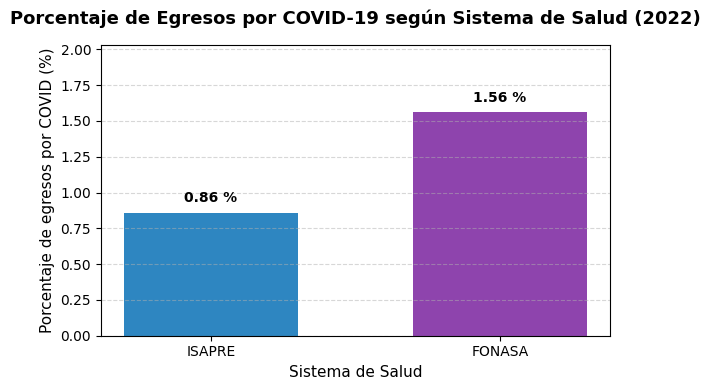

In [53]:

# Graficar
plt.figure(figsize=(6, 4))
colors = ["#2E86C1", "#8E44AD"]
bars = plt.bar(resumen_2022["Sistema"], resumen_2022["%_COVID_num"], color=colors, width=0.6)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.05,
             f"{bar.get_height():.2f} %",
             ha="center", va="bottom",
             fontsize=10, fontweight="bold")

ymax = resumen_2022["%_COVID_num"].max()
plt.ylim(0, ymax * 1.3)
plt.title("Porcentaje de Egresos por COVID-19 según Sistema de Salud (2022)",
          fontsize=13, fontweight="bold", pad=15)
plt.ylabel("Porcentaje de egresos por COVID (%)", fontsize=11)
plt.xlabel("Sistema de Salud", fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


**Combinar los datos para crear un gráfico comparativo de todos los años**

In [54]:
# Combinar datos
def ensure_pct(df):
    df = df.copy()
    if "%_COVID_num" in df.columns:
        return df
    if "%_COVID" in df.columns:
        x = (df["%_COVID"].astype(str)
             .str.replace("%","", regex=False)
             .str.replace(",",".", regex=False))
        df["%_COVID_num"] = pd.to_numeric(x, errors="coerce")
        return df
    df["%_COVID_num"] = (pd.to_numeric(df["Egresos_COVID"], errors="coerce") /
                         pd.to_numeric(df["Total_egresos"], errors="coerce")) * 100
    return df

r20 = ensure_pct(resumen).assign(Año=2020)[["Sistema","%_COVID_num","Año"]]
r21 = ensure_pct(resumen_2021).assign(Año=2021)[["Sistema","%_COVID_num","Año"]]
r22 = ensure_pct(resumen_2022).assign(Año=2022)[["Sistema","%_COVID_num","Año"]]

comp = pd.concat([r20, r21, r22], ignore_index=True)
comp["Sistema"] = comp["Sistema"].astype(str).str.upper()

**Crear el gráfico**

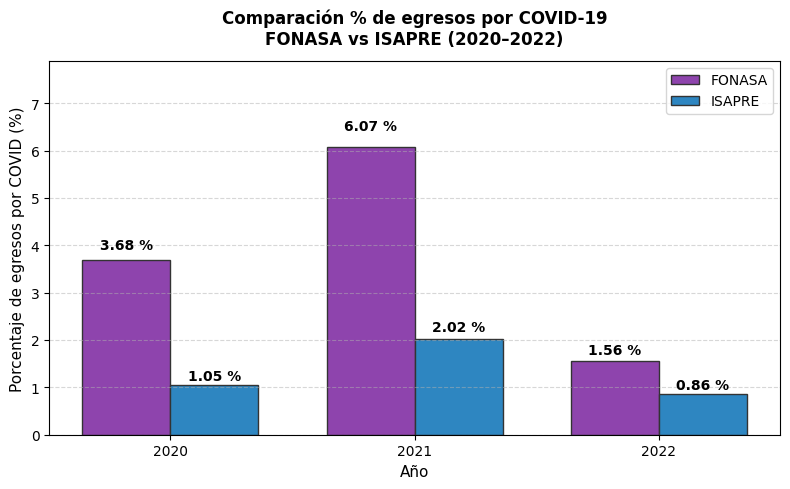

In [55]:

# Preparar datos
years   = sorted(comp["Año"].unique())
vals_fonasa = [comp.loc[(comp["Año"]==y)&(comp["Sistema"]=="FONASA"), "%_COVID_num"].astype(float).iloc[0]
               for y in years]
vals_isapre = [comp.loc[(comp["Año"]==y)&(comp["Sistema"]=="ISAPRE"), "%_COVID_num"].astype(float).iloc[0]
               for y in years]

x = np.arange(len(years))
width = 0.36

# Graficar
plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - width/2, vals_fonasa, width, label="FONASA", color="#8E44AD", edgecolor="#333", linewidth=1.0)
bars2 = plt.bar(x + width/2, vals_isapre, width, label="ISAPRE", color="#2E86C1", edgecolor="#333", linewidth=1.0)

def annotate(bars):
    for b in bars:
        y = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, y + (0.02 if y==0 else y*0.05),
                 f"{y:.2f} %", ha="center", va="bottom", fontsize=10, fontweight="bold")

annotate(bars1)
annotate(bars2)

ymax = float(np.nanmax(vals_fonasa + vals_isapre)) if (vals_fonasa+vals_isapre) else 0.0
plt.ylim(0, ymax*1.3 if ymax>0 else 1)
plt.xticks(x, [str(y) for y in years])
plt.xlabel("Año", fontsize=11)
plt.ylabel("Porcentaje de egresos por COVID (%)", fontsize=11)
plt.title("Comparación % de egresos por COVID-19\nFONASA vs ISAPRE (2020–2022)",
          pad=12, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
